In [7]:
#Code Prototype for Multivariate 1D use on EXCLAIM Project with multiple sensors, code by Joaquin Matticoli

In [8]:
import numpy as np
import filterpy
from filterpy.kalman import KalmanFilter as kf
from filterpy.kalman import predict
from filterpy.kalman import update
from numpy.random import randn
#from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
#import filterpy.stats as stats
import math
from math import sqrt

In [9]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

np.random.seed(24)

def print_gh(predict, update, z1, z2, K):
    predict_template = '{: 7.3f} {: 8.3f}'
    update_template = '{:.3f}\t{:.3f}\t{: 7.3f} {: 7.3f}   {:.3f}'

    print(predict_template.format(predict[0], predict[1]),end='\t')
    print(update_template.format(z1, z2, update[0], update[1], K))

In [10]:
class PayloadSimulation(object):
    def __init__(self, x0=0, angular_velocity2=1,
                 measurement1_var=0.0, measurement2_var = 0.0,
                 process_var=0.0):
        """ x0 : initial orientation
            angular_velocity: (+=counterclockwise, -=clockwise)
            measurement_var: variances in measurement deg^2
            process_var: variance in process (deg/s)^2
        """
        self.x = x0
        self.angular_velocity = angular_velocity2
        self.meas1_std = sqrt(measurement1_var)
        self.meas2_std = sqrt(measurement2_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new orientation of the payload in dt seconds."""
        dx = self.angular_velocity + abs(randn()*self.process_std)
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new orientation in degrees."""
        measurement = self.x + abs(randn()*self.meas1_std)
        return measurement
    
    def sense_velocity(self):
        """ Returns measurement of new angular velocity in deg/sec."""
        measurement2 = self.angular_velocity + abs(randn()*self.meas2_std)
        return measurement2

    def move_and_sense(self):
        """ Move payload, and return measurement of new orientation in degrees"""
        self.move()
        return self.sense_position()

In [11]:
printcase = 1 # If set to 1 it will print out the results
plotcov = 0 # If set to 1 it will plot the covariance results, printing this alongside data causes issues with spacing but still works
plotcase = 1 # If set to 1 it will plot results

#-----------USER INPUT STARTS------------------------------

number_of_variables = 2 #number of variables being measured
number_of_sensors = 2 #number of sensors used
process_var = 5. # variance in the payload's movement
sensor1_var = 2. # variance in the first sensor
sensor2_var = 0.5 # variance in second sensor
x = gaussian(0., 100.)  # payload's initial guess of orientation in deg and initial variance
angular_velocity = 0.5 # angular velocity in deg/s
spectral_density = 0.2 #Spectral density of the measurement noise
dt = 1. # time step in seconds
total_time = 30 # Total time passed from beginning to end of experiment

#-----------USER INPUT ENDS--------------------------------

process_model = gaussian(angular_velocity, process_var) # displacement to add to x
n_iter = math.floor(total_time/dt)

    #NOTE: this code will assume that orientation is always increasing/decreasing and not sinusodial because a more complext Kalman filter is needed for those cases
    
# simulate payload and get measurements
payload = PayloadSimulation(
    x0=x.mean, 
    angular_velocity2=process_model.mean, 
    measurement1_var=sensor1_var, 
    measurement2_var=sensor2_var,
    process_var=process_model.var)

# creates list of measurements, NOTE: modify this section if measurements are provided
zs, zs2, ztrue = [], [], []
for _ in range(n_iter):
    zs.append(payload.move_and_sense())
    zs2.append(payload.sense_velocity())
    ztrue.append(payload.x)
finalposition = payload.x

PREDICT					UPDATE
     x      var		  z1	  z2	    x      var      K
  0.500  105.067	4.561	0.724	  4.486   1.961   0.981
  5.206    2.499	7.702	1.517	  6.693   1.073   0.536
  7.966    1.599	8.368	1.650	  8.218   0.844   0.422
  9.689    1.362	9.901	1.836	  9.852   0.764   0.382
 11.497    1.279	11.738	0.840	 11.400   0.733   0.367
 12.708    1.248	16.047	1.248	 13.898   0.721   0.360
 15.373    1.237	15.591	1.445	 15.444   0.716   0.358
 16.919    1.233	18.591	0.545	 17.299   0.715   0.357
 18.468    1.232	19.101	0.501	 18.538   0.714   0.357
 19.455    1.231	22.034	1.234	 20.449   0.714   0.357
 21.655    1.231	23.630	1.693	 22.474   0.714   0.357
 24.006    1.231	28.381	1.977	 25.671   0.714   0.357
 27.652    1.231	28.043	0.915	 27.542   0.714   0.357
 29.084    1.231	30.088	0.705	 29.246   0.714   0.357
 30.485    1.231	34.343	1.229	 31.859   0.714   0.357
 33.319    1.231	34.001	0.533	 33.346   0.714   0.357
 34.444    1.231	38.667	1.703	 36.092   0.714   0.357
 37.700    1.231	4

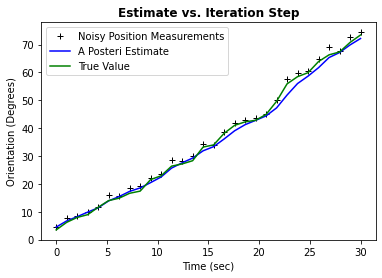

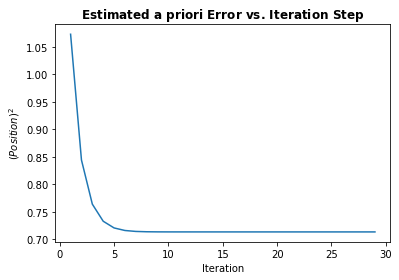

In [12]:
def plotstuff():
    plt.figure()
    plt.plot(np.linspace(0,total_time,len(zs)),zs,'k+',label='Noisy Position Measurements')
    #plt.plot(np.linspace(0,total_time,len(x1)),x1,'r*',label='A Priori Estimate')
    plt.plot(np.linspace(0,total_time,len(xhat)),xhat,'b-',label='A Posteri Estimate')
    plt.plot(np.linspace(0,total_time,len(ztrue)),ztrue,color='g',label='True Value')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Time (sec)')
    plt.ylabel('Orientation (Degrees)')
    
    plt.figure()
    valid_iter = range(1,n_iter) # Phat not valid at step 0
    plt.plot(valid_iter,Phat[valid_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Position)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()
    
def plotstuff2():
    from filterpy.stats import plot_covariance_ellipse
    plt.title('Covariance Map Around Random Point (10,10)', fontweight='bold')
    plot_covariance_ellipse((10,10),f.P, edgecolor='k', ls='dashed')

# x1 = np.zeros(n_iter) #Estimate before update
Phat = np.zeros(n_iter) #Variance after update
xhat = np.zeros(n_iter) #Estimate after update
counter = 0
if printcase == 1:
    print('PREDICT\t\t\t\t\tUPDATE')
    print('     x      var\t\t  z1\t  z2\t    x      var      K')

# perform Kalman filter on measurement(s) z
f = kf(dim_x=number_of_variables, dim_z=number_of_sensors)
f.F = np.array([[1., dt], [0., 1.]]) #correct for calculating position from position and velocity
f.H = np.array([[1., 0.], [0., 1.]]) #this is for first sensor measuring position and second one velocity
f.x = np.array([[x.mean], [angular_velocity*dt]])
f.Q *= np.array([[(dt**3)/3, (dt**2)/2],
                  [(dt**2)/2,  dt      ]]) *spectral_density
f.P = np.diag([x.var,process_var]) #Variance
f.R = np.diag([sensor1_var, sensor2_var])  #Noise in sensors

for i in range(n_iter):    
    f.predict()
    prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
    f.update(np.array([zs[i], zs2[i]]))
    x = gaussian(f.x[0,0], f.P[0,0])
    if printcase == 1:
        print_gh(prior, x, zs[i], zs2[i], f.K[0,0])
    if plotcase == 1:
#         x1[i] = prior.mean
        xhat[i] = x.mean
        Phat[i] = x.var
    if plotcov == 1:
        print()
        plotstuff2()

if printcase == 1:
    print()
    print('Final estimate:           {:10.3f}'.format(x.mean))
    print('Actual final orientation: {:10.3f}'.format(payload.x))
if plotcase == 1:
    print()
    plotstuff()